# Verkehrszeichenerkennung in Dashcam-Videos
Dieses Notebook lädt ein Eingangs-Video, erkennt Verkehrszeichen mit einem vortrainierten YOLOv5-Modell und erstellt ein Ausgangsvideo mit eingeblendeten Schildernamen.

## Schritte:
1. Imports und Setup
2. Video laden
3. Modell laden
4. Erkennung und Untertitelung
5. Ausgabevideo speichern


#import os
#os.system("pip freeze | xargs pip uninstall -y")

In [1]:
%pip install -r requirements_notebook.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
import warnings
from IPython.display import display

%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)

print(torch.__version__)

torch.cuda.is_available()

2.7.0


False

In [3]:
import yaml

with open('../yolo_training/yolo_training.yaml', 'r') as f:
    data = yaml.safe_load(f)

class_names = data['names']
print(f"{len(class_names)} Klassen geladen:")
print(class_names)

43 Klassen geladen:
['speed_limit_20', 'speed_limit_30', 'speed_limit_50', 'speed_limit_60', 'speed_limit_70', 'speed_limit_80', 'end_speed_limit_80', 'speed_limit_100', 'speed_limit_120', 'no_overtaking', 'no_overtaking_trucks', 'priority_at_next_intersection', 'priority_road', 'give_way', 'stop', 'no_entry', 'no_trucks', 'no_entry_both_directions', 'general_caution', 'curve_left', 'curve_right', 'double_curve', 'uneven_road', 'slippery_road', 'road_narrows', 'roadworks', 'traffic_signal', 'pedestrian_crossing', 'children', 'bikes', 'snow', 'wild_animals', 'no_speed_limit_overtake', 'turn_right', 'turn_left', 'go_straight', 'go_straight_or_right', 'go_straight_or_left', 'keep_right', 'keep_left', 'roundabout', 'end_no_overtaking', 'end_no_overtaking_trucks']


In [4]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/denti/.cache/torch/hub/master.zip


/Users/denti/.cache/torch/hub/ultralytics_yolov5_master/utils/general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
YOLOv5 🚀 2025-7-16 Python-3.13.5 torch-2.7.0 CPU

Fusing layers... 
Model summary: 157 layers, 7126096 parameters, 0 gradients, 16.1 GFLOPs
Adding AutoShape... 


In [5]:
video_path = 'input_videos/cv_regen_1_niedrige_qualität.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Fehler: Video konnte nicht geöffnet werden.")
else:
    print("Video erfolgreich geöffnet.")

ret, frame = cap.read()
if not ret:
    print("Kein Frame gelesen.")
else:
    print("Frame gelesen:", frame.shape)

fps = cap.get(cv2.CAP_PROP_FPS)
print("Video-FPS:", fps)


Video erfolgreich geöffnet.
Frame gelesen: (720, 1280, 3)
Video-FPS: 29.97002997002997


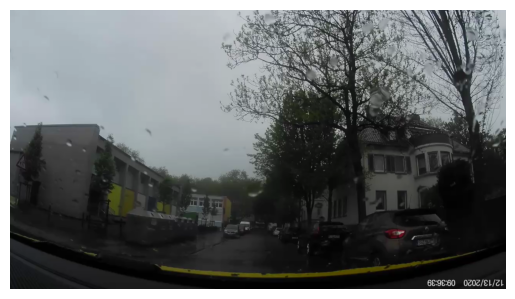

In [6]:
img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(img_rgb)
ax.axis('off')
display(fig)
plt.close(fig)

In [ ]:
# OUTPUT-VIDEO 640 x 640

# Schwellenwerte
CONF_THRESHOLD = 0.3
MAX_BOX_AREA_RATIO = 0.08
MAX_FRAMES = 999999
FRAME_START = 0

# Frame-Parameter
FRAME_H = 720
FRAME_W = 1280

# Rescaling der Frames, so dass es zum Modell passt
TARGET_W = 640
TARGET_H = 360
SCALE = 2
PADDING_V = 140
PADDING_H = 0

# Modellparameter
MODEL_INPUT_SIZE = 640

# Abgeleitete Werte
MAX_BOX_AREA = MAX_BOX_AREA_RATIO * FRAME_W * FRAME_H

# Initialisierung
frame_count = FRAME_START

cap.release()
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

output_path = 'output_videos/ergebnis_640.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_frame_size = (MODEL_INPUT_SIZE, MODEL_INPUT_SIZE)
writer = cv2.VideoWriter(output_path, fourcc, fps, output_frame_size)
print("VideoWriter initialisiert.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(frame_rgb, (TARGET_W, TARGET_H))
    img_resized = cv2.copyMakeBorder(resized, PADDING_V, PADDING_V, PADDING_H, PADDING_H, cv2.BORDER_CONSTANT, value=(114, 114, 114))

    input_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    with torch.no_grad():
        preds = model(input_tensor)[0].cpu().tolist()

    for pred in preds:
        # print(f"pred: {pred}")
        cx, cy, w, h = pred[0], pred[1], pred[2], pred[3]
        objectness = pred[4]
        class_scores = pred[5:]

        max_score = max(class_scores)
        conf = objectness * max_score
        if conf < CONF_THRESHOLD:
            continue

        cls_index = class_scores.index(max_score)
        print(f"conf={conf:.4f} für Klasse {cls_index}")

        x1 = int(cx - w / 2)
        y1 = int(cy - h / 2)
        x2 = int(cx + w / 2)
        y2 = int(cy + h / 2)

        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(MODEL_INPUT_SIZE, x2)
        y2 = min(MODEL_INPUT_SIZE, y2)

        print(f"Rechteck: {x1},{y1} -> {x2},{y2}")
        box_area = (x2 - x1) * (y2 - y1)

        label = class_names[cls_index]
        cv2.rectangle(img_resized, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_resized, label, (10, MODEL_INPUT_SIZE - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        print(f"Gezeichnet: {label}")

    writer.write(cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"{frame_count} Frames verarbeitet.")

    if frame_count >= MAX_FRAMES:
        print(f"Es wurden {MAX_FRAMES} Frames verarbeitet und die Verarbeitung wird beendet.")
        break     

cap.release()
writer.release()
print("Fertig.")


VideoWriter initialisiert.
100 Frames verarbeitet.
200 Frames verarbeitet.
300 Frames verarbeitet.
400 Frames verarbeitet.
500 Frames verarbeitet.
600 Frames verarbeitet.
700 Frames verarbeitet.
800 Frames verarbeitet.
900 Frames verarbeitet.
1000 Frames verarbeitet.
1100 Frames verarbeitet.
1200 Frames verarbeitet.
1300 Frames verarbeitet.
1400 Frames verarbeitet.
1500 Frames verarbeitet.
1600 Frames verarbeitet.
1700 Frames verarbeitet.
1800 Frames verarbeitet.
1900 Frames verarbeitet.
2000 Frames verarbeitet.
Es wurden 2000 Frames verarbeitet und die Verarbeitung wird beendet.
Fertig.


In [ ]:
# OUTPUT-VIDEO 1280 x 720

# Schwellenwerte
CONF_THRESHOLD = 0.6
MAX_BOX_AREA_RATIO = 0.08
MAX_FRAMES = 100
FRAME_START = 0

# Frame-Parameter
FRAME_H = 720
FRAME_W = 1280

# Rescaling der Frames, so dass es zum Modell passt
TARGET_W = 640
TARGET_H = 360
SCALE = 2
PADDING_V = 140
PADDING_H = 0

# Modellparameter
MODEL_INPUT_SIZE = 640

# Abgeleitete Werte
MAX_BOX_AREA = MAX_BOX_AREA_RATIO * FRAME_W * FRAME_H

# Initialisierung
frame_count = FRAME_START

cap.release()
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

output_path = 'output_videos/ergebnis.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_frame_size = (FRAME_W, FRAME_H)

writer = cv2.VideoWriter(output_path, fourcc, fps, output_frame_size)
print("VideoWriter initialisiert.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(frame_rgb, (TARGET_W, TARGET_H))
    img_resized = cv2.copyMakeBorder(resized, PADDING_V, PADDING_V, PADDING_H, PADDING_H, cv2.BORDER_CONSTANT, value=(114, 114, 114))

    input_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    with torch.no_grad():
        preds = model(input_tensor)[0].cpu().tolist()

    for pred in preds:
        # print(f"pred: {pred}")
        cx, cy, w, h = pred[0], pred[1], pred[2], pred[3]
        objectness = pred[4]
        class_scores = pred[5:]

        max_score = max(class_scores)
        conf = objectness * max_score
        if conf < CONF_THRESHOLD:
            continue

        cls_index = class_scores.index(max_score)
        print(f"conf={conf:.4f} für Klasse {cls_index}")

        x1 = cx - w / 2
        y1 = cy - h / 2
        x2 = cx + w / 2
        y2 = cy + h / 2

        draw_x1 = int(x1 * SCALE)
        draw_y1 = int((y1 - PADDING_V) * SCALE)
        draw_x2 = int(x2 * SCALE)
        draw_y2 = int((y2 - PADDING_V) * SCALE)

        draw_x1 = max(0, draw_x1)
        draw_y1 = max(0, draw_y1)
        draw_x2 = min(FRAME_W, draw_x2)
        draw_y2 = min(FRAME_H, draw_y2)
        print(f"Rechteck: {draw_x1},{draw_y1} -> {draw_x2},{draw_y2}")

        box_area = (draw_x2 - draw_x1) * (draw_y2 - draw_y1)
        #if box_area > MAX_BOX_AREA:
        #    print(f"Übersprungen wegen Größe: {box_area}px")
        #    continue

        label = class_names[cls_index]
        cv2.rectangle(frame, (draw_x1, draw_y1), (draw_x2, draw_y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        print(f"Gezeichnet: {label}")

    writer.write(frame)

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"{frame_count} Frames verarbeitet.")

    if frame_count >= MAX_FRAMES:
        print(f"Es wurden {MAX_FRAMES} Frames verarbeitet und die Verarbeitung wird beendet.")
        break     

cap.release()
writer.release()
print("Fertig.")
